In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from tqdm import tqdm
import seaborn as sns
from sklearn.manifold import TSNE

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Constants
BATCH_SIZE = 128
LATENT_DIM = 20
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
NUM_MEMORIES = 40000 # here num memories decides how many images are used to train the hopfield network and the number of memories to train the vae
BETA = 0.5  # Temperature parameter for Hopfield Network
MEMORIES_DIR = '/content/drive/MyDrive/NUS/mhn_memories'


In [ ]:
def reset_memories_directory():
    """Delete and recreate the memories directory"""
    if os.path.exists(MEMORIES_DIR):
        print(f"Deleting existing {MEMORIES_DIR} directory...")
        shutil.rmtree(MEMORIES_DIR)
    print(f"Creating new {MEMORIES_DIR} directory...")
    os.makedirs(MEMORIES_DIR)

class ModernHopfieldNetwork:
    def __init__(self, beta=0.5):
        self.beta = beta
        self.memories = None

    def store(self, patterns):
        self.memories = patterns.float()

    def update(self, state, num_iterations=5):
        batch_size = state.size(0)

        for _ in range(num_iterations):
            # Compute similarity matrix
            similarities = torch.matmul(state, self.memories.t())

            # Apply softmax with temperature
            attention = F.softmax(similarities / self.beta, dim=1)

            # Update state
            state = torch.matmul(attention, self.memories)

        return state

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()


        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)


        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

def generate_random_noise(batch_size, input_dim):
    """Generate random noise between 0 and 1"""
    return torch.rand(batch_size, input_dim)

def generate_hopfield_memories(hopfield_net, num_memories, input_dim=784):
    """Generate memories using random noise as input to Hopfield network"""
    batch_size = 1000
    num_batches = num_memories // batch_size
    memories = []

    for i in tqdm(range(num_batches), desc="Generating Hopfield memories"):
        # Generate random noise
        noise = generate_random_noise(batch_size, input_dim)

        # Get Hopfield network output
        with torch.no_grad():
            memory = hopfield_net.update(noise)
            memories.append(memory)

            # Save batch of memories
            torch.save(memory, os.path.join(MEMORIES_DIR, f'memories_batch_{i}.pt'))

    return torch.cat(memories, dim=0)

def load_hopfield_memories():
    """Load previously generated Hopfield memories"""
    memories = []
    for filename in sorted(os.listdir(MEMORIES_DIR)):
        if filename.startswith('memories_batch_'):
            memory = torch.load(os.path.join(MEMORIES_DIR, filename))
            memories.append(memory)
    return torch.cat(memories, dim=0)

def train_vae(vae, train_loader, device, num_epochs=NUM_EPOCHS):
    optimizer = torch.optim.Adam(vae.parameters(), lr=LEARNING_RATE)
    reconstruction_losses = []
    kl_losses = []

    for epoch in tqdm(range(num_epochs), desc="Training VAE"):
        epoch_recon_loss = 0
        epoch_kl_loss = 0
        num_batches = 0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()

            recon_batch, mu, log_var = vae(data)

            # Reconstruction loss
            recon_loss = F.binary_cross_entropy(recon_batch, data, reduction='sum')

            # KL divergence loss
            kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

            # Total loss
            loss = recon_loss + kl_loss

            loss.backward()
            optimizer.step()

            epoch_recon_loss += recon_loss.item()
            epoch_kl_loss += kl_loss.item()
            num_batches += 1

        avg_recon_loss = epoch_recon_loss / (num_batches * BATCH_SIZE)
        avg_kl_loss = epoch_kl_loss / (num_batches * BATCH_SIZE)
        reconstruction_losses.append(avg_recon_loss)
        kl_losses.append(avg_kl_loss)

    return reconstruction_losses, kl_losses

def plot_results(noisy_image, hopfield_output, vae_output, index):
    """Plot results with index in title"""
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.imshow(noisy_image.reshape(28, 28), cmap='gray')
    plt.title(f'Random Noise Input {index}')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(hopfield_output.reshape(28, 28), cmap='gray')
    plt.title(f'Hopfield Network Output {index}')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(vae_output.reshape(28, 28), cmap='gray')
    plt.title(f'VAE Output {index}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def plot_training_curves(reconstruction_losses, kl_losses):
    plt.figure(figsize=(12, 5))

    plt.subplot(121)
    plt.plot(reconstruction_losses)
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(122)
    plt.plot(kl_losses)
    plt.title('KL Divergence Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

def plot_latent_space(vae, memory_loader, device):
    vae.eval()
    latent_vectors = []

    with torch.no_grad():
        for data, _ in memory_loader:
            data = data.to(device)
            mu, _ = vae.encode(data)
            latent_vectors.append(mu.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)

    # Use t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_vectors)

    plt.figure(figsize=(10, 8))
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.5)
    plt.title('Latent Space Visualization (t-SNE)')
    plt.show()

Using device: cuda
Deleting existing /content/drive/MyDrive/NUS/mhn_memories directory...
Creating new /content/drive/MyDrive/NUS/mhn_memories directory...
Generating new Hopfield memories from random noise...


Training VAE: 100%|██████████| 50/50 [01:09<00:00,  1.39s/it]


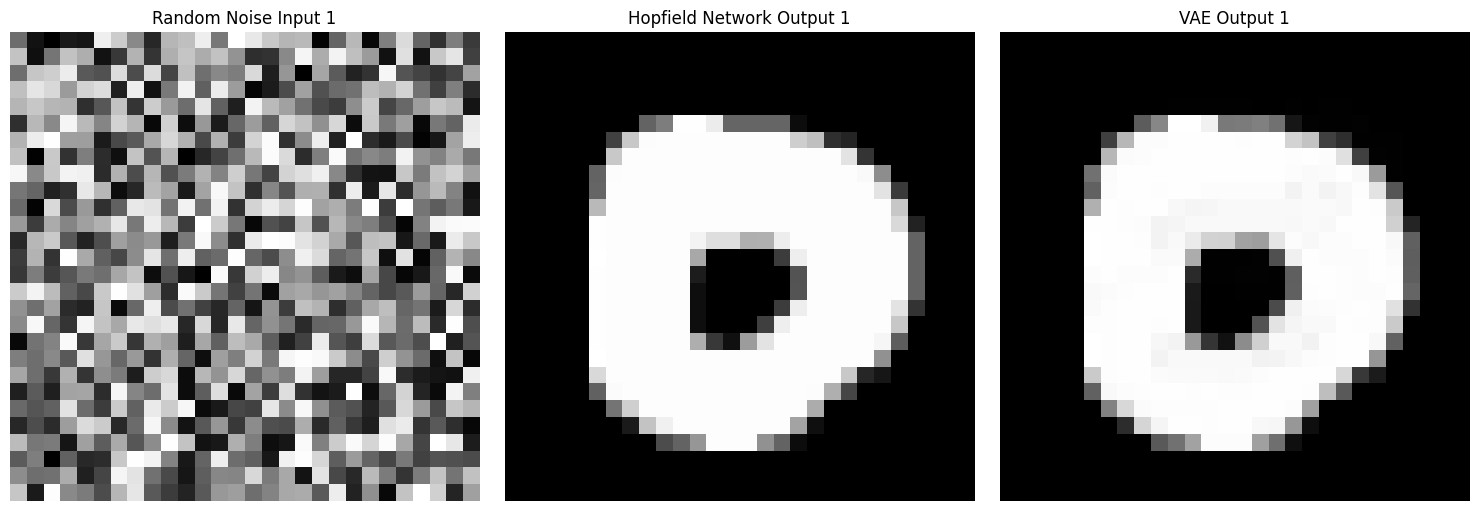

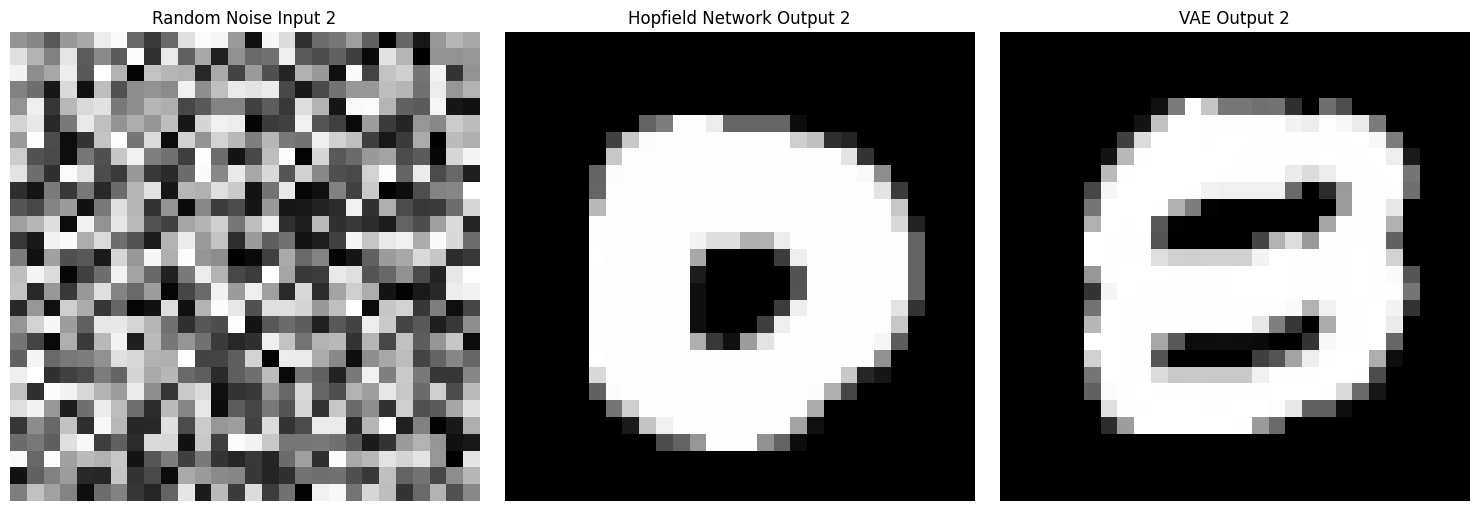

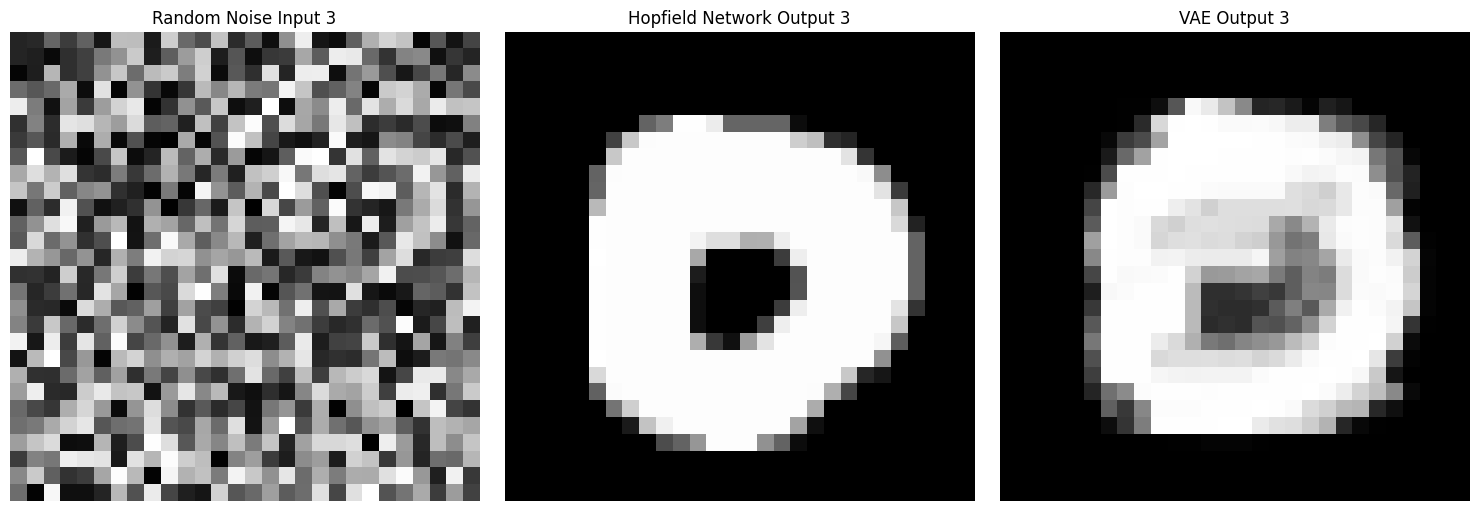

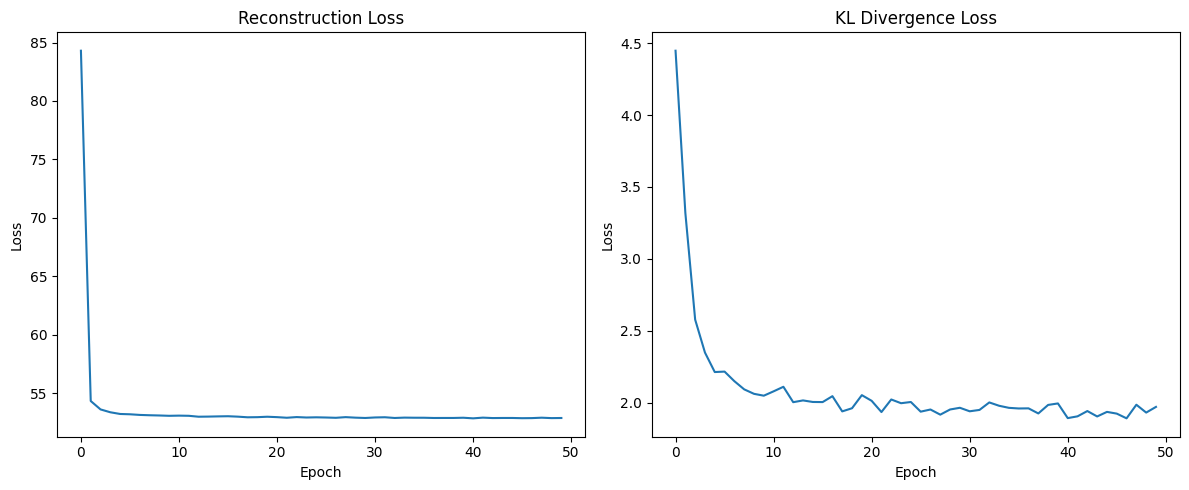

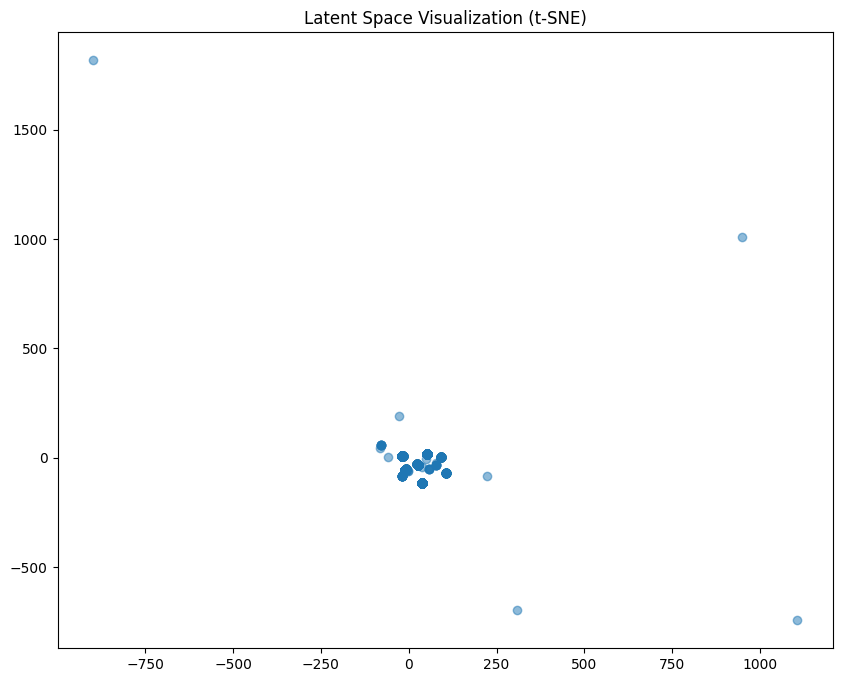

In [16]:
def main():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Reset memories directory
    reset_memories_directory()

    # Load MNIST dataset for initial Hopfield memories
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    mnist_train = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(mnist_train, batch_size=NUM_MEMORIES, shuffle=True)
    images, _ = next(iter(train_loader))
    memories = images.view(NUM_MEMORIES, -1)

    # Initialize and store patterns in Hopfield Network
    hopfield = ModernHopfieldNetwork(beta=BETA)
    hopfield.store(memories)

    # Generate new memories from random noise
    print("Generating new Hopfield memories from random noise...")
    hopfield_memories = generate_hopfield_memories(hopfield, NUM_MEMORIES)

    # Initialize VAE and prepare data loader for training
    vae = VAE().to(device)
    memory_dataset = TensorDataset(hopfield_memories, torch.zeros(NUM_MEMORIES))
    memory_loader = DataLoader(memory_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Train VAE on Hopfield memories
    reconstruction_losses, kl_losses = train_vae(vae, memory_loader, device)

    # Generate and plot multiple examples
    num_examples = 3
    for i in range(num_examples):
        # Generate random noise
        noisy_image = generate_random_noise(1, 784)

        # Get Hopfield output
        hopfield_output = hopfield.update(noisy_image)

        # Get VAE output
        vae.eval()
        with torch.no_grad():
            noisy_image_device = noisy_image.to(device)
            vae_output, _, _ = vae(noisy_image_device)
            vae_output = vae_output.cpu()

        # Plot results
        plot_results(noisy_image[0], hopfield_output[0], vae_output[0], i+1)

    # Plot training curves
    plot_training_curves(reconstruction_losses, kl_losses)

    # Plot latent space
    plot_latent_space(vae, memory_loader, device)

if __name__ == "__main__":
    main()